## Comparison of CNN Models for Mass Detection in Mammography Images

### Setup

First we install any necessary packages.

In [3]:
!pip install pydicom
!pip install livelossplot

print('Installed packages.')

     |████████████████████████████████| 35.3MB 88kB/s 
Installed packages.


Then we load the packages.

In [6]:
import os
import pydicom
import cv2
import plistlib
import random
import livelossplot
import numpy as np
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf
import pandas as pd

from tqdm import tqdm
from sklearn import preprocessing
from sklearn.feature_extraction import image
from sklearn.utils import shuffle
from skimage.draw import polygon
from skimage.util import view_as_blocks
from skimage.transform import rotate
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
from keras.applications import vgg19, resnet_v2, nasnet, densenet

print('Loaded packages.')

Loaded packages.


Here's some shared code for the pre-processing and train/evaluation steps.

In [0]:
patch_size = (224,224)
input_shape = patch_size + (3,)

## Pre-processing
Patch extraction and zero mean normalization. We write to a Google Drive to store the data and labels, so this section doesn't need to be run unless you need to perform pre-processing again. If you're satisfied with the Google Drive contents, you can proceed to the next section.

We load the [INBreast](https://github.com/wentaozhu/deep-mil-for-whole-mammogram-classification/issues/12) dataset from Dropbox.

In [7]:
!wget -O inbreast https://www.dropbox.com/sh/k0e06yayf50kspe/AADmoROCuzfffA6EhRKSqghGa?dl=0 inbreast
!unzip inbreast -d /inbreast

print('Loaded INBreast.')

--2020-05-04 09:33:55--  https://www.dropbox.com/sh/k0e06yayf50kspe/AADmoROCuzfffA6EhRKSqghGa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/k0e06yayf50kspe/AADmoROCuzfffA6EhRKSqghGa [following]
--2020-05-04 09:33:55--  https://www.dropbox.com/sh/raw/k0e06yayf50kspe/AADmoROCuzfffA6EhRKSqghGa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceb2e876092946a5f8d2ca829ba.dl.dropboxusercontent.com/zip_download_get/AaeO6fARsRDXgbrVUyAgli_cq3VaSduoFyvMLx-u4rZ8AIR3R74DngJB0XZT-uXeHh9Nb5wWqK_F30XaCL-RhNr99iMEg0GzG5VXzuQ6WthVlA [following]
--2020-05-04 09:33:57--  https://uceb2e876092946a5f8d2ca829ba.dl.dropboxusercontent.com/zip_download_get/AaeO6fARsRDXgbrVUyAgli_cq3VaSduoFyvMLx-u4rZ8AIR3R74DngJB0XZT-uXeHh9Nb5wWqK_F30XaCL-R

This is a utility for loading INBreast ROIs.

In [0]:
def load_inbreast_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """
    result = []
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            mask = np.zeros(imshape)
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            assert numPoints == len(points)
            points = [eval(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[1]), int(point[0])] = 1
            else:
                x, y = zip(*points)
                col, row = np.array(x), np.array(y) ##x coord is the column coord in an image and y is the row
                poly_x, poly_y = polygon(row, col, shape=imshape)
                mask[poly_x, poly_y] = 1
            # store indices for nonzero points so that patches containing tumors
            # can be extracted
            locations_of_interest = np.nonzero(mask)
            coords = np.array(locations_of_interest).T
            x_coords, y_coords = np.nonzero(mask)
            x_min = np.min(x_coords)
            x_max = np.max(x_coords)
            y_min = np.min(y_coords)
            y_max = np.max(y_coords)
            if x_min == x_max:
              x_min -= 5
              x_max += 5
            if y_min == y_max:
              y_min -= 5
              y_max += 5
            bounding_box = (x_min, x_max, y_min, y_max)
            result.append(bounding_box)
    return coords, result

print('Defined INBreast ROI loading utility.')

Then we load the INBreast ROIs.

In [3]:
inbreast_xml = '../inbreast/xml'
inbreast_rois = {}

files = os.listdir(inbreast_xml)
with tqdm(total=len(files)) as t:
  for filename in files:
    coords, regions = load_inbreast_mask(os.path.join(inbreast_xml, filename))
    inbreast_rois[filename.split('.')[0]] = coords
    t.update()

print('Finished loading ROIs.')

100%|██████████| 343/343 [35:07<00:00,  6.14s/it]

Finished loading ROIs.


We extract patches from the input as a pre-processing step, following [Agarwal et al.](https://www.spiedigitallibrary.org/journals/journal-of-medical-imaging/volume-6/issue-03/031409/Automatic-mass-detection-in-mammograms-using-deep-convolutional-neural-networks/10.1117/1.JMI.6.3.031409.full?SSO=1) This is also where data augmentation of positive examples, through horizontal flipping and random rotation, and zero mean normalization occurs.

In [4]:
inbreast_dicom = '../inbreast/dicom'
display = False
N = 1000

X = np.zeros((N,)+input_shape)
Y = np.zeros((N,))

n = 0
dicom_files = os.listdir(inbreast_dicom)
with tqdm(total=len(dicom_files)) as t:
  for filename in dicom_files:
    if filename.endswith(".dcm"):
      patient_image = pydicom.dcmread(os.path.join(inbreast_dicom, filename)).pixel_array
      patient_id = filename.split('_')[0]
      # excluding border regions
      current_i = patch_size[0]
      current_j = patch_size[1]
      max_i, max_j = patient_image.shape
      while current_i + 2*patch_size[0] < max_i:
        next_i = current_i + patch_size[0]
        while current_j + 2*patch_size[1] < max_j:
          next_j = current_j + patch_size[1]
          patch = patient_image[current_i:next_i, current_j:next_j]
          mean, sd = cv2.meanStdDev(patch)
          current_j = next_j
          if sd[0,0] == 0:
            continue
          if patient_id in inbreast_rois:
            positive = False
            for x_coord, y_coord in inbreast_rois[patient_id]:
              if current_i <= x_coord <= next_i and current_j <= y_coord <= next_j:
                positive = True
                break
            if positive:
              Y[n] = 1
              Y[n+1] = 1
              Y[n+2] = 1
            else:
              if random.random() > 0.99:
                Y[n] = 0
              else:
                continue
          else:
            continue
          normalized_patch = (patch-mean)/sd
          broadcasted_patch = normalized_patch[:, :, None] * np.ones(3, dtype=int)[None, None, :]
          X[n] = broadcasted_patch
          if positive:
            X[n+1] = cv2.flip(broadcasted_patch, 0) # augment data with horizontal flips
            X[n+2] = rotate(broadcasted_patch, random.randint(0, 40))
            n += 3
          else:
            n += 1
        current_i = next_i
        current_j = 0
    t.update()

assert X.shape[0] == Y.shape[0]
print('Number of examples:', X.shape[0])
print('Number of positive examples:', np.sum(Y))

print('Finished pre-processing INBreast data.')

100%|██████████| 413/413 [08:20<00:00,  1.21s/it]

(1000, 224, 224, 3)
(1000,)
Number of examples: 1000
Number of positive examples: 408.0
Finished loading images.
Finished loading INBreast data.


Here we write the pre-processed data to a Google Drive so we can load it more easily later. You'll need to provide an authorization code when prompted, if you haven't mounted Google Drive before.

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/')
!mkdir -p 6.802
np.save('6.802/data.npy', X)
np.save('6.802/labels.npy', Y)

print('Saved pre-processed data to Google Drive.')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


FileNotFoundError: ignored

## Training and Evaluation
Start here if you already have pre-processed data in Google Drive.

First we'll test the GPU. Change to a GPU like this:

1.   Navigate to Edit→Notebook Settings
2.   select GPU from the Hardware Accelerator drop-down

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Here we load the pre-processed data from Google Drive. You'll need to mount Google Drive if you haven't done so above.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

if os.path.exists('gdrive/My Drive/'):
  os.chdir('gdrive/My Drive/')
raw_X = np.load('6.802/data.npy')
raw_Y = np.load('6.802/labels.npy')

print('Loaded pre-processed data from Google Drive.')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Loaded pre-processed data from Google Drive.


Here we split the data into train, test, and validation sets (60-20-20).

In [11]:
lb = preprocessing.LabelBinarizer()
lb.fit([0,1])
binarized_labels = lb.transform(raw_Y)

X, Y = shuffle(raw_X, np.hstack((binarized_labels, 1 - binarized_labels)))
n = X.shape[0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

print('Split data into train and test sets.')

Split data into train and test sets.


We use convolutional bases pre-trained on ImageNet and fine-tune them for the mass detection task.

In [14]:
vgg19 = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
resnet152vt = resnet_v2.ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)
nasnetmobile = nasnet.NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)
densenet201 = densenet.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

print('Loaded convolutional bases.')

19996672/19993432 [==============================] - 1s 0us/step
Loaded convolutional bases.


The top of the network will be custom made, and we will test various architectures.

In [15]:
# Each function takes in a convolutional base and returns a Keras model that
# uses the convolutional base and adds a classifier on top.

def make_model_dense(conv_base):
  model = K.models.Sequential()
  model.add(conv_base)
  model.add(K.layers.Flatten())
  model.add(K.layers.Dense(1024, activation='relu'))
  model.add(K.layers.Dropout(0.5))
  model.add(K.layers.Dense(2, activation='softmax'))
  model.summary()
  return model

print('Defined model makers.')

Defined model makers.


Here we train and evaluate the model.

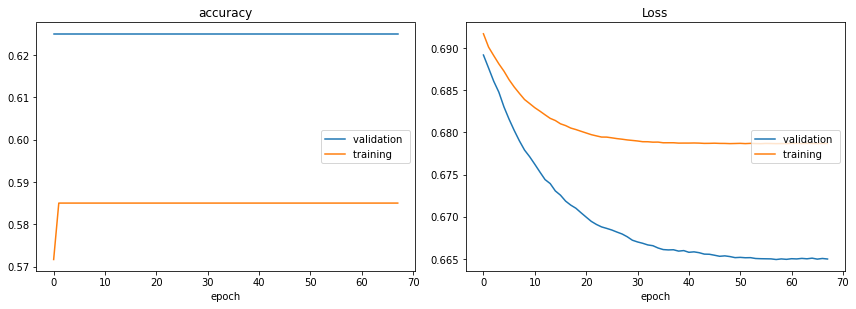

accuracy
	validation       	 (min:    0.235, max:    0.625, cur:    0.625)
	training         	 (min:    0.515, max:    0.585, cur:    0.585)
Loss
	validation       	 (min:    0.665, max:    9.680, cur:    0.665)
	training         	 (min:    0.678, max:  937.319, cur:    0.679)
Epoch 00068: early stopping
200/200 [==============================] - 2s 11ms/step


ValueError: ignored

In [22]:
BATCH_SIZE = 64
EPOCHS = 100
plot_losses = livelossplot.PlotLossesKeras()
es = K.callbacks.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

def train_model(model):
  model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  model.fit(X_train, Y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[plot_losses, es],
            verbose=1,
            validation_split = 0.25)
  
def evaluate_model(model):
  Y_pred = model.predict(X_test)
  evaluation = model.evaluate(X_test, Y_test)
  return Y_pred, evaluation

def get_results_for_model(conv_base, make_model_func):
  model = make_model_func(conv_base)
  train_model(model)
  Y_pred, evaluation = evaluate_model(model)
  auc = roc_auc_score(Y_test, Y_pred)
  fpr, tpr, thresholds = roc_curve(Y_test[:,0], Y_pred[:,0])
  plt.plot(fpr, tpr)
  print('AUC ROC:', auc)
  print('loss:', evaluation[0])
  print('accuracy:', evaluation[1])

with tf.device('/device:GPU:0'):
  get_results_for_model(vgg19, make_model_dense)

print('Trained and evaluated models.')